In [38]:
import os
import sys
import numpy as np
import time
import tensorflow as tf

import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import utils 

Reading in model from Tensor Flow 

In [39]:
url = "http://download.tensorflow.org/models/mobilenet_v1_2018_08_02/mobilenet_v1_1.0_224_quant.tgz"
dir_name = "models/mobilenet_v1"    
utils.maybe_download(dir_name, url)

Files already exists


Methods quantize data

In [40]:
np.random.seed(1515)
x = (1*np.random.randn(9,9)).astype(np.float32)

def sat_uint(x, num_bits=8):
    return np.uint8(np.clip(np.round(x), 0, 2**num_bits-1))

def quantize(x_float, num_bits=8, print_debug=False):
    # calculate scale
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min

    quant_min = 0    
    quant_max = 2**num_bits - 1

    x_scale = (x_max - x_min)/(quant_max - quant_min)
    
    # calculate offset
    x_offset = sat_uint(quant_max - x_max/x_scale, num_bits)
    
    # quantize
    x_quant = x_float/x_scale + x_offset

    if print_debug:
        print("min = %f \nmax = %f \nnum_bits = %d \nscale = %.8f \noffset = %d"\
              %(x_min, x_max, num_bits, x_scale, x_offset))
    return sat_uint(x_quant, num_bits), x_scale, x_offset

def dequantize(x_quant, x_scale, x_offset):
    
    x_quant = x_quant.astype(np.float32)
    
    x_dequant = (x_quant - x_offset) * x_scale
    
    return x_dequant

x_quant, x_scale, x_offset = quantize(x, 8, True)

x_dequant = dequantize(x_quant, x_scale, x_offset)

min = -2.398871 
max = 2.760502 
num_bits = 8 
scale = 0.02023283 
offset = 119


Preparing directories

In [41]:
fpaths = glob(dir_name+"/*")
file_sizes = [os.path.getsize(f)/2**20 for f in fpaths]
sort_indices = np.argsort(file_sizes)
for i in sort_indices:
    print("%s \t%.1f MB"%(fpaths[i].split('/')[-1], file_sizes[i]))

mobilenet_v1\mobilenet_v1_1.0_224_quant_info.txt 	0.0 MB
mobilenet_v1\mobilenet_v1_1.0_224_quant.ckpt.index 	0.0 MB
mobilenet_v1\mobilenet_v1_1.0_224_quant_eval.pbtxt 	0.8 MB
mobilenet_v1\mobilenet_v1_1.0_224_quant.tflite 	4.1 MB
mobilenet_v1\mobilenet_v1_1.0_224_quant.ckpt.meta 	4.9 MB
mobilenet_v1\mobilenet_v1_1.0_224_quant.ckpt.data-00000-of-00001 	16.2 MB
mobilenet_v1\mobilenet_v1_1.0_224_quant_frozen.pb 	16.4 MB
mobilenet_v1\mobilenet_v1_1.0_224_quant.tgz 	33.4 MB


In [42]:
utils.print_file(dir_name, 'mobilenet_v1_1.0_224_quant_info.txt')

Model: mobilenet_v1_1.0_224_quant

Input: input

Output: MobilenetV1/Predictions/Reshape_1



In [43]:
model_name = 'mobilenet_v1_1.0_224_quant.tflite'
model_path = os.path.join(dir_name, model_name)
interpreter = tf.lite.Interpreter(model_path=model_path)
                                          
interpreter.allocate_tensors()

In [6]:
input_details = interpreter.get_input_details()
input_details[0]
input_index = input_details[0]['index']
input_tensor = interpreter.get_tensor(input_index)

Preparing to shape tensors 

In [7]:
num_layer = 89
for i in range(num_layer):
    detail = interpreter._get_tensor_details(i)
    print(i, detail['name'])

0 MobilenetV1/Logits/AvgPool_1a/AvgPool
1 MobilenetV1/Logits/Conv2d_1c_1x1/BiasAdd
2 MobilenetV1/Logits/Conv2d_1c_1x1/Conv2D_bias
3 MobilenetV1/Logits/Conv2d_1c_1x1/weights_quant/FakeQuantWithMinMaxVars
4 MobilenetV1/Logits/SpatialSqueeze
5 MobilenetV1/Logits/SpatialSqueeze_shape
6 MobilenetV1/MobilenetV1/Conv2d_0/Conv2D_Fold_bias
7 MobilenetV1/MobilenetV1/Conv2d_0/Relu6
8 MobilenetV1/MobilenetV1/Conv2d_0/weights_quant/FakeQuantWithMinMaxVars
9 MobilenetV1/MobilenetV1/Conv2d_10_depthwise/Relu6
10 MobilenetV1/MobilenetV1/Conv2d_10_depthwise/depthwise_Fold_bias
11 MobilenetV1/MobilenetV1/Conv2d_10_depthwise/weights_quant/FakeQuantWithMinMaxVars
12 MobilenetV1/MobilenetV1/Conv2d_10_pointwise/Conv2D_Fold_bias
13 MobilenetV1/MobilenetV1/Conv2d_10_pointwise/Relu6
14 MobilenetV1/MobilenetV1/Conv2d_10_pointwise/weights_quant/FakeQuantWithMinMaxVars
15 MobilenetV1/MobilenetV1/Conv2d_11_depthwise/Relu6
16 MobilenetV1/MobilenetV1/Conv2d_11_depthwise/depthwise_Fold_bias
17 MobilenetV1/MobilenetV1/

In [8]:
print(os.listdir("images"))

['cat.jpg', 'gold_fish.jpg', 'red_fox.jpg']


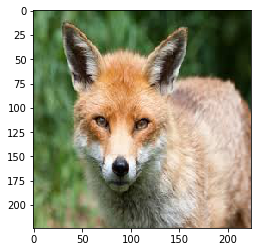

In [9]:
def load_image(img_path):
    
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    return img

img_path = "images/red_fox.jpg"
img = load_image(img_path)
plt.imshow(img)

In [10]:
input_image = np.array(img)
input_image = np.expand_dims(input_image, axis=0)
print("image shape:", input_image.shape)
print("image data type:", input_image.dtype)


image shape: (1, 224, 224, 3)
image data type: uint8


In [11]:
import time
input_details = interpreter.get_input_details()
input_index = input_details[0]['index']

start_time = time.time()

interpreter.set_tensor(input_index, input_image)
interpreter.invoke()


output_details = interpreter.get_output_details()
output_index = output_details[0]['index']
output_data = interpreter.get_tensor(output_index)

elapsed = time.time()-start_time
print("inference time: %.1f ms"%(1000*elapsed))

inference time: 275.2 ms


(1, 1001)


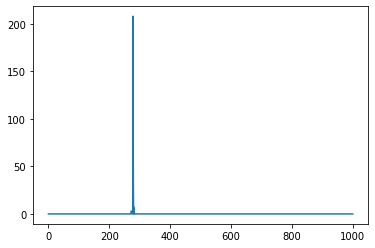

In [12]:
print(output_data.shape)
plt.plot(output_data[0,:])

In [37]:
confidence = output_data[0,:]/np.sum(output_data)

top5_idx = np.flip(np.argsort(confidence))[:5]
print("id", "    confidence\t", "class name")
for i in top5_idx:
    label_name = utils.imagenet_id_to_class(i)
    print(i,"\t%.1f%%\t"%(100*confidence[i]), label_name,)

id     confidence	 class name
278 	81.6%	 red fox, Vulpes vulpes
279 	12.9%	 kit fox, Vulpes macrotis
281 	2.7%	 grey fox, gray fox, Urocyon cinereoargenteus
272 	1.2%	 red wolf, maned wolf, Canis rufus, Canis niger
273 	1.2%	 coyote, prairie wolf, brush wolf, Canis latrans


Confirming Linear Mapping is held. Ensures assumptions are held. 

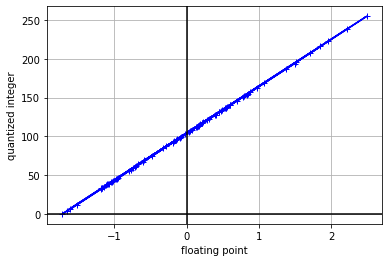

In [35]:
fig, ax = plt.subplots()
ax.plot(x, x_quant, marker='+',color='b')
ax.set_xlabel("floating point")
ax.set_ylabel("quantized integer")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.grid(True)